# Population Density of Mexican States and Municipalities

This Notebook downloads Geopandas GeoDataFrames for States (admin1) and Municipalities (admin2) derived from the 2020 Mexican Census: [INEGI](https://www.inegi.org.mx/temas/mg/).

For details how these dataframe were created, see the [mexican-boundaries](https://github.com/sbl-sdsc/mexico-boundaries) GitHub project.

In [1]:
from io import BytesIO
from urllib.request import urlopen
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import ipywidgets as widgets

In [2]:
pd.options.display.max_rows = None  # display all rows
pd.options.display.max_columns = None  # display all columsns

## Boundaries of Mexican Municipalities

Read boundary polygons for Mexican states from shapefile

In [3]:
admin2_url = 'https://raw.githubusercontent.com/sbl-sdsc/mexico-boundaries/main/data/mexico_admin2.parquet'

In [4]:
resp = urlopen(admin2_url)
admin2 = gpd.read_parquet(BytesIO(resp.read()))

Calculate the area of each state (convert area from m^2 to km^2

In [5]:
admin2.crs

<Projected CRS: PROJCRS["MEXICO_ITRF_2008_LCC",BASEGEOGCRS["MEXICO ...>
Name: MEXICO_ITRF_2008_LCC
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: International Terrestrial Reference Frame 2008
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [6]:
admin2['area_sqkm'] = admin2['geometry'].area/ 10**6

In [7]:
admin2['CVE_MUNI'] = admin2['CVE_ENT'] + admin2['CVE_MUN']

In [8]:
admin2.head()

,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,area_sqkm,CVE_MUNI
0,01001,01,001,Aguascalientes,"POLYGON ((2489072.503 1115771.584, 2489352.774...",1166.359248,01001
1,01002,01,002,Asientos,"POLYGON ((2494680.261 1141224.505, 2494749.948...",543.374266,01002
2,01003,01,003,Calvillo,"POLYGON ((2429607.454 1120262.254, 2429071.902...",923.357832,01003
3,01004,01,004,Cosío,"POLYGON ((2470517.824 1155028.588, 2470552.248...",128.383545,01004
4,01005,01,005,Jesús María,"POLYGON ((2465526.729 1114740.466, 2465752.546...",499.895092,01005


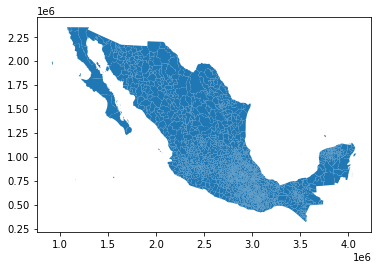

In [9]:
admin2.plot();

## Map of Population by Municipality

Get population from COVID-19 data files

In [10]:
population_admin2 = pd.read_csv('../data/Casos_Diarios_Municipio_Defunciones_20210627.csv', 
                                usecols=['cve_ent', 'poblacion', 'nombre'])

In [11]:
population_admin2.head()

,cve_ent,poblacion,nombre
0,16046,15290,Juarez
1,16047,22358,Jungapeo
2,16048,5862,Lagunillas
3,16049,18769,Madero
4,5035,744247,Torreon


Add 5-digit municipality code column (example: convert 5035 -> 05035)

In [12]:
population_admin2['CVE_MUNI'] = population_admin2['cve_ent'].apply(lambda i: f'{i:05d}')

In [13]:
population_admin2.head()

,cve_ent,poblacion,nombre,CVE_MUNI
0,16046,15290,Juarez,16046
1,16047,22358,Jungapeo,16047
2,16048,5862,Lagunillas,16048
3,16049,18769,Madero,16049
4,5035,744247,Torreon,05035


Merge the geo dataframe with the population dataframe using the common CVE_MUNI column

In [14]:
df_admin2 = admin2.merge(population_admin2, on='CVE_MUNI')

In [15]:
df_admin2.head()

,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,area_sqkm,CVE_MUNI,cve_ent,poblacion,nombre
0,01001,01,001,Aguascalientes,"POLYGON ((2489072.503 1115771.584, 2489352.774...",1166.359248,01001,1001,961977,Aguascalientes
1,01002,01,002,Asientos,"POLYGON ((2494680.261 1141224.505, 2494749.948...",543.374266,01002,1002,50864,Asientos
2,01003,01,003,Calvillo,"POLYGON ((2429607.454 1120262.254, 2429071.902...",923.357832,01003,1003,60760,Calvillo
3,01004,01,004,Cosío,"POLYGON ((2470517.824 1155028.588, 2470552.248...",128.383545,01004,1004,16918,Cosio
4,01005,01,005,Jesús María,"POLYGON ((2465526.729 1114740.466, 2465752.546...",499.895092,01005,1005,130184,Jesus Maria


Calculate population density

In [16]:
df_admin2['population_density'] = df_admin2['poblacion'] / df_admin2['area_sqkm']

Plot population data

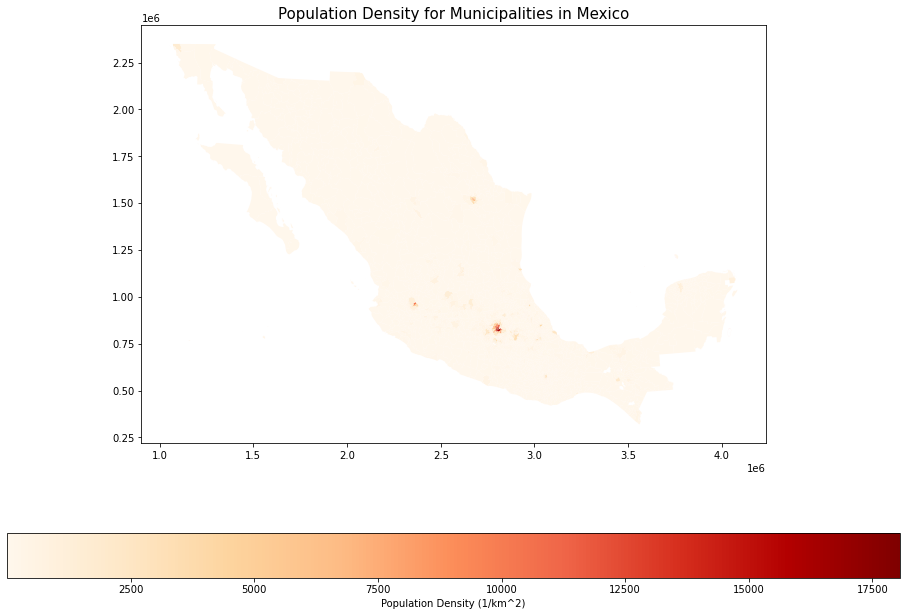

In [17]:
title = 'Population Density for Municipalities in Mexico'
ax1 = df_admin2.plot(column='population_density', 
                     cmap='OrRd',
                     legend=True, 
                     legend_kwds={'label': 'Population Density (1/km^2)', 
                                  'orientation': 'horizontal'},
                     figsize=(16, 11));
ax1.set_title(title, fontsize=15);

## View Population Density for Municipalities in a selected State

Get info for states

In [18]:
admin1_url = 'https://raw.githubusercontent.com/sbl-sdsc/mexico-boundaries/main/data/mexico_admin1.parquet'

In [19]:
resp = urlopen(admin1_url)
admin1 = pd.read_parquet(BytesIO(resp.read()), columns=['CVE_ENT','NOMGEO'])

Get the list of states

In [20]:
states = admin1['NOMGEO'].unique()

Create a dropdown menu of the states.

In [21]:
state_widget = widgets.Dropdown(options=states, description='Select state:', value='Aguascalientes')

In [22]:
display(state_widget)

Dropdown(description='Select state:', options=('Aguascalientes', 'Baja California', 'Baja California Sur', 'Ca…

Get the selected state

In [23]:
state = state_widget.value

Filter dataframe by state code

In [24]:
state_code = admin1.query(f'NOMGEO == "{state}"')['CVE_ENT'].values[0]
df_state = df_admin2.query(f'CVE_ENT == "{state_code}"')

In [25]:
df_state.head()

,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,area_sqkm,CVE_MUNI,cve_ent,poblacion,nombre,population_density
0,01001,01,001,Aguascalientes,"POLYGON ((2489072.503 1115771.584, 2489352.774...",1166.359248,01001,1001,961977,Aguascalientes,824.769043
1,01002,01,002,Asientos,"POLYGON ((2494680.261 1141224.505, 2494749.948...",543.374266,01002,1002,50864,Asientos,93.607672
2,01003,01,003,Calvillo,"POLYGON ((2429607.454 1120262.254, 2429071.902...",923.357832,01003,1003,60760,Calvillo,65.803308
3,01004,01,004,Cosío,"POLYGON ((2470517.824 1155028.588, 2470552.248...",128.383545,01004,1004,16918,Cosio,131.777013
4,01005,01,005,Jesús María,"POLYGON ((2465526.729 1114740.466, 2465752.546...",499.895092,01005,1005,130184,Jesus Maria,260.422641


In [26]:
title = f'Population Density for Municipalities in {state}'

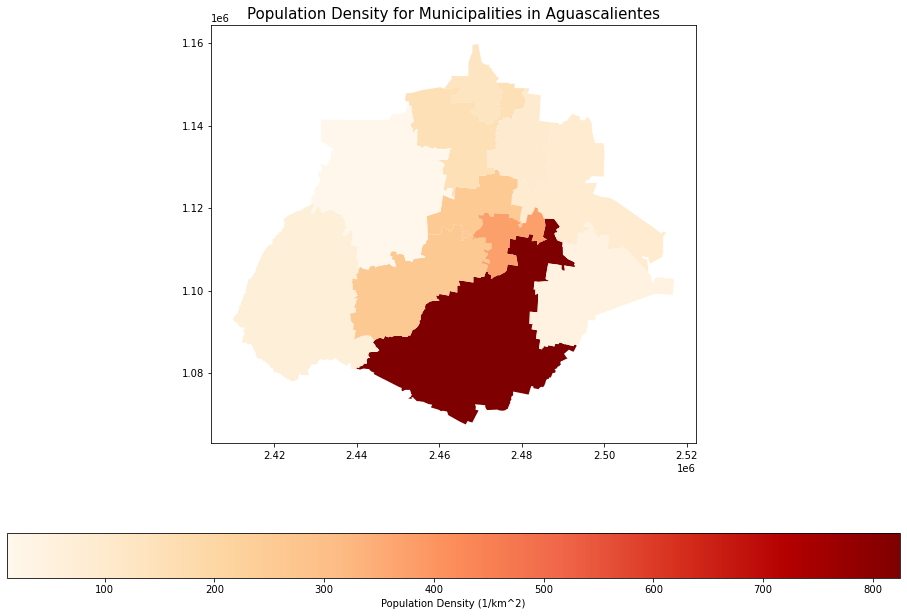

In [27]:
ax2 = df_state.plot(column='population_density', 
                     cmap='OrRd',
                     legend=True, 
                     legend_kwds={'label': 'Population Density (1/km^2)', 
                                  'orientation': 'horizontal'},
                     figsize=(16, 11));
ax2.set_title(title, fontsize=15);